# Seldon and TensorFlow Serving MNIST Example

This example shows how you can combine Seldon with Tensorflo Serving. We will use a Seldon Tensorflow Serving proxy model image that will forward Seldon internal microservice prediction calls out to a Tensorflow serving server.

The example will use the MNIST digit classification task with the example MNIST model.


# Setup

In [30]:
%matplotlib inline
import requests
from random import randint,random
import json
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import sys
sys.path.append("../../../notebooks")
from visualizer import get_graph

In [31]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

def download_mnist():
    return input_data.read_data_sets("MNIST_data/", one_hot = True)

def rest_predict_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/predict",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_transform_input_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/transform-input",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_transform_output_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/transform-output",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_request_ambassador(deploymentName,endpoint="localhost:8003",arr=None):
    payload = {"data":{"names":["a","b"],"tensor":{"shape":[1,784],"values":arr.tolist()}}}
    response = requests.post(
                "http://"+endpoint+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload)
    print(response.status_code)
    print(response.text)


def gen_mnist_data(mnist):
    batch_xs, batch_ys = mnist.train.next_batch(1)
    chosen=0
    gen_image(batch_xs[chosen]).show()
    data = batch_xs[chosen].reshape((1,784))
    return data


In [32]:
mnist = download_mnist()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Create MNIST Model

In [10]:
# CHANGE THIS TO YOUR OWN CHOSEN GOOGLE BUCKET NAME
%env MODEL_REPOSITORY_BUCKET=seldon-tfserving-store

env: MODEL_REPOSITORY_BUCKET=seldon-tfserving-store


In [11]:
!gsutil mb gs://${MODEL_REPOSITORY_BUCKET}

Creating gs://seldon-tfserving-store/...


In [12]:
!gsutil cp -r mnist-model gs://${MODEL_REPOSITORY_BUCKET}

Copying file://mnist-model/1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://mnist-model/1/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://mnist-model/1/variables/variables.index [Content-Type=application/octet-stream]...
\ [3 files][ 48.7 KiB/ 48.7 KiB]                                                
Operation completed over 3 objects/48.7 KiB.                                     


# Test From GCP Cluster

## Run MNIST Inference Graph

In [22]:
!kubectl -n kube-system create sa tiller
!kubectl create clusterrolebinding tiller --clusterrole cluster-admin --serviceaccount=kube-system:tiller
!helm init --service-account tiller

serviceaccount "tiller" created
clusterrolebinding "tiller" created
$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [23]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


In [24]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd \
    --set usage_metrics.enabled=true

NAME:   seldon-core-crd
LAST DEPLOYED: Sat Sep 22 20:12:29 2018
NAMESPACE: kubeflow
STATUS: DEPLOYED

RESOURCES:
==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     1s

==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  1s

==> v1beta1/Deployment
NAME                        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-spartakus-volunteer  1        0        0           0          1s

==> v1/ServiceAccount
NAME                        SECRETS  AGE
seldon-spartakus-volunteer  1        1s

==> v1beta1/ClusterRole
NAME                        AGE
seldon-spartakus-volunteer  0s

==> v1beta1/ClusterRoleBinding
NAME                        AGE
seldon-spartakus-volunteer  0s


NOTES:
NOTES: TODO




In [25]:
!kubectl create namespace seldon

namespace "seldon" created


In [26]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "gke_kubeflow-testing-213813_europe-west4-a_cluster-1" modified.


In [33]:
!helm install ../../../helm-charts/seldon-core --name seldon-core \
        --namespace seldon \
        --set ambassador.enabled=true \
        --set apife.image.name=127.0.0.1:5000/seldonio/apife:0.2.4-SNAPSHOT \
        --set cluster_manager.image.name=127.0.0.1:5000/seldonio/cluster-manager:0.2.4-SNAPSHOT \
        --set cluster_manager.image.pull_policy=Always \
        --set engine.image.name=127.0.0.1:5000/seldonio/engine:0.2.4-SNAPSHOT

NAME:   seldon-core
LAST DEPLOYED: Sat Sep 22 20:28:07 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ClusterRoleBinding
NAME    AGE
seldon  0s

==> v1/Pod(related)
NAME                                                 READY  STATUS             RESTARTS  AGE
seldon-core-ambassador-778c58bf5d-vpdjp              0/2    ContainerCreating  0         0s
seldon-core-seldon-apiserver-6cb45f8db7-qzcgh        0/1    ContainerCreating  0         0s
seldon-core-seldon-cluster-manager-8485f8c994-vk6jz  0/1    ContainerCreating  0         0s
seldon-core-redis-8668565565-j894v                   0/1    ContainerCreating  0         0s

==> v1/ServiceAccount
NAME    SECRETS  AGE
seldon  1        0s

==> v1beta1/ClusterRole
NAME        AGE
seldon-crd  0s

==> v1beta1/Role
seldon-local  0s
ambassador    0s

==> v1beta1/RoleBinding
NAME        AGE
ambassador  0s

==> v1/RoleBinding
seldon  0s

==> v1/Service
NAME                          TYPE       CLUSTER-IP     EXTERNAL-IP  PORT(S)           

In [35]:
!kubectl rollout status deploy/seldon-core-seldon-cluster-manager
!kubectl rollout status deploy/seldon-core-seldon-apiserver

deployment "seldon-core-seldon-cluster-manager" successfully rolled out
deployment "seldon-core-seldon-apiserver" successfully rolled out


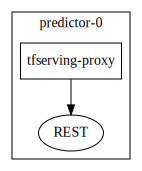

In [36]:
get_graph("mnist_tfserving_deployment.json")

In [ ]:
!kubectl create -f mnist_tfserving_deployment.json

**Port forward Ambassador**

```
kubectl port-forward $(kubectl get pods -n seldon -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080
```

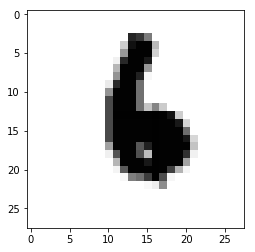

200
{
  "meta": {
    "puid": "s5s03bld7st413nn81f5pghepd",
    "tags": {
    },
    "routing": {
    }
  },
  "data": {
    "names": [],
    "tensor": {
      "shape": [10],
      "values": [1.1656718645891573E-10, 1.7612658211874077E-6, 0.001473270240239799, 0.01945633254945278, 3.1624003895558417E-4, 4.613793280441314E-4, 0.9547215104103088, 3.3344885186359363E-10, 0.023473011329770088, 9.646773105487227E-5]
    }
  }
}


In [40]:
data = gen_mnist_data(mnist)
data = data.reshape((784))
rest_request_ambassador("tfserving-mnist",endpoint="localhost:8003",arr=data)

## Analytics and Load Test

In [2]:
!helm install ../../../helm-charts/seldon-core-analytics --name seldon-core-analytics \
    --set grafana_prom_admin_password=password \
    --set persistence.enabled=false \
    --namespace seldon

NAME:   seldon-core-analytics
LAST DEPLOYED: Sat Sep 22 11:11:24 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/Job
NAME                            DESIRED  SUCCESSFUL  AGE
grafana-prom-import-dashboards  1        0           0s

==> v1beta1/Deployment
NAME                     DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
alertmanager-deployment  1        1        1           0          0s
grafana-prom-deployment  1        1        1           0          0s
prometheus-deployment    1        1        1           0          0s

==> v1beta1/DaemonSet
NAME                      DESIRED  CURRENT  READY  UP-TO-DATE  AVAILABLE  NODE SELECTOR  AGE
prometheus-node-exporter  1        1        0      1           0          <none>         0s

==> v1/Pod(related)
NAME                                      READY  STATUS             RESTARTS  AGE
grafana-prom-import-dashboards-vxn4r      0/1    ContainerCreating  0         0s
alertmanager-deployment-557b99ccf8-xrplx  0/1    ContainerCreating

In [4]:
!kubectl label nodes $(kubectl get nodes -o jsonpath='{.items[0].metadata.name}') role=locust

node "gke-cluster-1-default-pool-d23f60ab-mk5g" labeled


In [49]:
!helm install seldon-core-loadtesting --name loadtest  \
    --namespace seldon \
    --repo https://storage.googleapis.com/seldon-charts \
    --set locust.script=mnist_rest_locust.py \
    --set locust.host=http://caffe2-mnist:8000 \
    --set oauth.enabled=false \
    --set locust.hatchRate=1 \
    --set locust.clients=1 \
    --set loadtest.sendFeedback=1 \
    --set locust.minWait=0 \
    --set locust.maxWait=0 \
    --set replicaCount=1 \
    --set data.size=784


NAME:   loadtest
LAST DEPLOYED: Sat Sep 22 15:28:11 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ReplicationController
NAME             DESIRED  CURRENT  READY  AGE
locust-slave-1   1        1        0      0s
locust-master-1  1        1        0      0s

==> v1/Service
NAME             TYPE      CLUSTER-IP     EXTERNAL-IP  PORT(S)                                       AGE
locust-master-1  NodePort  10.39.247.242  <none>       5557:30345/TCP,5558:30445/TCP,8089:30226/TCP  0s

==> v1/Pod(related)
NAME                   READY  STATUS             RESTARTS  AGE
locust-slave-1-c4nnv   0/1    ContainerCreating  0         0s
locust-master-1-2hzcl  0/1    ContainerCreating  0         0s




You should port-foward the grafana dashboard

```
kubectl port-forward $(kubectl get pods -n seldon -l app=grafana-prom-server -o jsonpath='{.items[0].metadata.name}') -n seldon 3000:3000
```

You can then view an analytics dashboard inside the cluster at http://localhost:3000/dashboard/db/prediction-analytics?refresh=5s&orgId=1. Your IP address may be different. get it via minikube ip. Login with:

    Username : admin

    password : password (as set when starting seldon-core-analytics above)